**Корректность проверена на Python 3.6:**
+ pandas 0.23.4
+ numpy 1.15.4
+ matplotlib 3.0.2
+ sklearn 0.20.2

In [280]:
import warnings
warnings.filterwarnings('ignore')

## Предобработка данных и логистическая регрессия для задачи бинарной классификации

## Programming assignment

В задании вам будет предложено ознакомиться с основными техниками предобработки данных, а так же применить их для обучения модели логистической регрессии. Ответ потребуется загрузить в соответствующую форму в виде 6 текстовых файлов.

In [281]:
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

## Описание датасета

Задача: по 38 признакам, связанных с заявкой на грант (область исследований учёных, информация по их академическому бэкграунду, размер гранта, область, в которой он выдаётся) предсказать, будет ли заявка принята. Датасет включает в себя информацию по 6000 заявкам на гранты, которые были поданы в университете Мельбурна в период с 2004 по 2008 год.

Полную версию данных с большим количеством признаков можно найти на https://www.kaggle.com/c/unimelb.

In [282]:
data = pd.read_csv('data.csv')
data.shape

(6000, 39)

Выделим из датасета целевую переменную Grant.Status и обозначим её за y
Теперь X обозначает обучающую выборку, y - ответы на ней

In [283]:
X = data.drop('Grant.Status', 1)
y = data['Grant.Status']

## Теория по логистической регрессии

После осознания того, какую именно задачу требуется решить на этих данных, следующим шагом при реальном анализе был бы подбор подходящего метода. В данном задании выбор метода было произведён за вас, это логистическая регрессия. Кратко напомним вам используемую модель.

Логистическая регрессия предсказывает вероятности принадлежности объекта к каждому классу. Сумма ответов логистической регрессии на одном объекте для всех классов равна единице.

$$ \sum_{k=1}^K \pi_{ik} = 1, \quad \pi_k \equiv P\,(y_i = k \mid x_i, \theta), $$

где:
- $\pi_{ik}$ - вероятность принадлежности объекта $x_i$ из выборки $X$ к классу $k$
- $\theta$ - внутренние параметры алгоритма, которые настраиваются в процессе обучения, в случае логистической регрессии - $w, b$

Из этого свойства модели в случае бинарной классификации требуется вычислить лишь вероятность принадлежности объекта к одному из классов (вторая вычисляется из условия нормировки вероятностей). Эта вероятность вычисляется, используя логистическую функцию:

$$ P\,(y_i = 1 \mid x_i, \theta) = \frac{1}{1 + \exp(-w^T x_i-b)} $$

Параметры $w$ и $b$ находятся, как решения следующей задачи оптимизации (указаны функционалы с L1 и L2 регуляризацией, с которыми вы познакомились в предыдущих заданиях):

L2-regularization:

$$ Q(X, y, \theta) = \frac{1}{2} w^T w + C \sum_{i=1}^l \log ( 1 + \exp(-y_i (w^T x_i + b ) ) ) \longrightarrow \min\limits_{w,b} $$

L1-regularization:

$$ Q(X, y, \theta) = \sum_{d=1}^D |w_d| + C \sum_{i=1}^l \log ( 1 + \exp(-y_i (w^T x_i + b ) ) ) \longrightarrow \min\limits_{w,b} $$

$C$ - это стандартный гиперпараметр модели, который регулирует то, насколько сильно мы позволяем модели подстраиваться под данные.

## Предобработка данных

Из свойств данной модели следует, что:
- все $X$ должны быть числовыми данными (в случае наличия среди них категорий, их требуется некоторым способом преобразовать в вещественные числа)
- среди $X$ не должно быть пропущенных значений (т.е. все пропущенные значения перед применением модели следует каким-то образом заполнить)

Поэтому базовым этапом в предобработке любого датасета для логистической регрессии будет кодирование категориальных признаков, а так же удаление или интерпретация пропущенных значений (при наличии того или другого).

In [284]:
data.head()
# data.info()

,Grant.Status,Sponsor.Code,Grant.Category.Code,Contract.Value.Band...see.note.A,RFCD.Code.1,RFCD.Percentage.1,RFCD.Code.2,RFCD.Percentage.2,RFCD.Code.3,RFCD.Percentage.3,RFCD.Code.4,RFCD.Percentage.4,RFCD.Code.5,RFCD.Percentage.5,SEO.Code.1,...,Person.ID.1,Role.1,Year.of.Birth.1,Country.of.Birth.1,Home.Language.1,Dept.No..1,Faculty.No..1,With.PHD.1,No..of.Years.in.Uni.at.Time.of.Grant.1,Number.of.Successful.Grant.1,Number.of.Unsuccessful.Grant.1,A..1,A.1,B.1,C.1
0,1,21A,50A,A,230202.0,50.0,230203.0,30.0,230204.0,20.0,0.0,0.0,0.0,0.0,780101.0,...,493297.0,CHIEF_INVESTIGATOR,1965.0,Australia,NaN,3098.0,31.0,Yes,>=0 to 5,2.0,0.0,0.0,4.0,2.0,0.0
1,1,4D,10A,D,320801.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,730112.0,...,330592.0,CHIEF_INVESTIGATOR,1965.0,Australia,NaN,2553.0,25.0,Yes,>=0 to 5,3.0,1.0,0.0,2.0,0.0,0.0
2,0,NaN,NaN,NaN,320602.0,50.0,321004.0,30.0,321015.0,20.0,0.0,0.0,0.0,0.0,730203.0,...,66887.0,CHIEF_INVESTIGATOR,1955.0,Australia,NaN,2813.0,25.0,NaN,Less than 0,1.0,5.0,0.0,7.0,2.0,0.0
3,0,51C,20C,A,291503.0,60.0,321402.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0,730114.0,...,63812.0,CHIEF_INVESTIGATOR,1950.0,Great Britain,NaN,2553.0,25.0,NaN,more than 15,2.0,1.0,5.0,6.0,9.0,1.0
4,0,24D,30B,NaN,380107.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,730108.0,...,13687.0,CHIEF_INVESTIGATOR,1970.0,Australia,NaN,2923.0,25.0,NaN,Less than 0,0.0,2.0,0.0,0.0,0.0,0.0


In [285]:
print(data.shape)

(6000, 39)


Видно, что в датасете есть как числовые, так и категориальные признаки. Получим списки их названий:

In [286]:
numeric_cols = ['RFCD.Percentage.1', 'RFCD.Percentage.2', 'RFCD.Percentage.3', 
                'RFCD.Percentage.4', 'RFCD.Percentage.5',
                'SEO.Percentage.1', 'SEO.Percentage.2', 'SEO.Percentage.3',
                'SEO.Percentage.4', 'SEO.Percentage.5',
                'Year.of.Birth.1', 'Number.of.Successful.Grant.1', 'Number.of.Unsuccessful.Grant.1']
categorical_cols = list(set(X.columns.values.tolist()) - set(numeric_cols))

Также в нём присутствуют пропущенные значения. Очевидны решением будет исключение всех данных, у которых пропущено хотя бы одно значение. Сделаем это:

In [287]:
X.dropna().shape
categorical_cols

['With.PHD.1',
 'Dept.No..1',
 'Home.Language.1',
 'SEO.Code.1',
 'RFCD.Code.4',
 'No..of.Years.in.Uni.at.Time.of.Grant.1',
 'SEO.Code.5',
 'Sponsor.Code',
 'RFCD.Code.1',
 'Role.1',
 'C.1',
 'RFCD.Code.2',
 'SEO.Code.2',
 'Country.of.Birth.1',
 'RFCD.Code.5',
 'B.1',
 'Grant.Category.Code',
 'SEO.Code.4',
 'RFCD.Code.3',
 'A..1',
 'Contract.Value.Band...see.note.A',
 'Person.ID.1',
 'Faculty.No..1',
 'SEO.Code.3',
 'A.1']

Видно, что тогда мы выбросим почти все данные, и такой метод решения в данном случае не сработает.

Пропущенные значения можно так же интерпретировать, для этого существует несколько способов, они различаются для категориальных и вещественных признаков.

Для вещественных признаков:
- заменить на 0 (данный признак давать вклад в предсказание для данного объекта не будет)
- заменить на среднее (каждый пропущенный признак будет давать такой же вклад, как и среднее значение признака на датасете)

Для категориальных:
- интерпретировать пропущенное значение, как ещё одну категорию (данный способ является самым естественным, так как в случае категорий у нас есть уникальная возможность не потерять информацию о наличии пропущенных значений; обратите внимание, что в случае вещественных признаков данная информация неизбежно теряется)

##  Задание 0. Обработка пропущенных значений.
1. Заполните пропущенные вещественные значения в X нулями и средними по столбцам, назовите полученные датафреймы X_real_zeros и X_real_mean соответственно. Для подсчёта средних используйте описанную ниже функцию calculate_means, которой требуется передать на вход вешественные признаки из исходного датафрейма. **Для подсчета среднего можно использовать функцию pandas.mean()**
2. Все категориальные признаки в X преобразуйте в строки, пропущенные значения требуется также преобразовать в какие-либо строки, которые не являются категориями (например, 'NA'), полученный датафрейм назовите X_cat.

Для объединения выборок здесь и далее в задании рекомендуется использовать функции

    np.hstack(...)
    np.vstack(...)

In [288]:
def calculate_means(numeric_data):
    means = np.zeros(numeric_data.shape[1])
    for j in range(numeric_data.shape[1]):
        to_sum = numeric_data.iloc[:,j]
        indices = np.nonzero(~numeric_data.iloc[:,j].isnull())[0]
        correction = np.amax(to_sum[indices])
        to_sum /= correction
        for i in indices:
            means[j] += to_sum[i]
        means[j] /= indices.size
        means[j] *= correction
    return pd.Series(means, numeric_data.columns)

In [289]:
X_real_zeros = X[numeric_cols].fillna(value=0)
X_real_mean = X[numeric_cols].fillna(X[numeric_cols].mean())
print(type(X_real_mean))

print(X[categorical_cols].shape)
X_cat = X[categorical_cols].fillna('NA')
for category in categorical_cols:
    X_cat[category] = X_cat[category].apply(str)
    
X_cat

<class 'pandas.core.frame.DataFrame'>
(6000, 25)


,With.PHD.1,Dept.No..1,Home.Language.1,SEO.Code.1,RFCD.Code.4,No..of.Years.in.Uni.at.Time.of.Grant.1,SEO.Code.5,Sponsor.Code,RFCD.Code.1,Role.1,C.1,RFCD.Code.2,SEO.Code.2,Country.of.Birth.1,RFCD.Code.5,B.1,Grant.Category.Code,SEO.Code.4,RFCD.Code.3,A..1,Contract.Value.Band...see.note.A,Person.ID.1,Faculty.No..1,SEO.Code.3,A.1
0,Yes,3098.0,NA,780101.0,0.0,>=0 to 5,0.0,21A,230202.0,CHIEF_INVESTIGATOR,0.0,230203.0,0.0,Australia,0.0,2.0,50A,0.0,230204.0,0.0,A,493297.0,31.0,0.0,4.0
1,Yes,2553.0,NA,730112.0,0.0,>=0 to 5,0.0,4D,320801.0,CHIEF_INVESTIGATOR,0.0,0.0,0.0,Australia,0.0,0.0,10A,0.0,0.0,0.0,D,330592.0,25.0,0.0,2.0
2,NA,2813.0,NA,730203.0,0.0,Less than 0,0.0,NA,320602.0,CHIEF_INVESTIGATOR,0.0,321004.0,730105.0,Australia,0.0,2.0,NA,0.0,321015.0,0.0,NA,66887.0,25.0,730108.0,7.0
3,NA,2553.0,NA,730114.0,0.0,more than 15,0.0,51C,291503.0,CHIEF_INVESTIGATOR,1.0,321402.0,671401.0,Great Britain,0.0,9.0,20C,0.0,0.0,5.0,A,63812.0,25.0,0.0,6.0
4,NA,2923.0,NA,730108.0,0.0,Less than 0,0.0,24D,380107.0,CHIEF_INVESTIGATOR,0.0,0.0,730306.0,Australia,0.0,0.0,30B,0.0,0.0,0.0,NA,13687.0,25.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,Yes,653.0,NA,750902.0,0.0,>=0 to 5,0.0,21A,430102.0,CHIEF_INVESTIGATOR,0.0,440207.0,750702.0,Australia,0.0,0.0,50A,0.0,379999.0,1.0,NA,10402.0,7.0,750401.0,1.0
5996,NA,NA,NA,NA,NA,NA,NA,163C,NA,CHIEF_INVESTIGATOR,0.0,NA,NA,NA,NA,0.0,10A,NA,NA,0.0,NA,102602.0,NA,NA,1.0
5997,Yes,2523.0,NA,730201.0,0.0,>10 to 15,0.0,112D,321204.0,CHIEF_INVESTIGATOR,5.0,321208.0,730211.0,Australia,0.0,2.0,30C,0.0,321210.0,2.0,A,68587.0,25.0,730204.0,2.0
5998,NA,1798.0,NA,NA,NA,Less than 0,NA,NA,NA,CHIEF_INVESTIGATOR,2.0,NA,NA,Australia,NA,1.0,NA,NA,NA,0.0,A,16757.0,118.0,NA,0.0


## Преобразование категориальных признаков.

В предыдущей ячейке мы разделили наш датасет ещё на две части: в одной присутствуют только вещественные признаки, в другой только категориальные. Это понадобится нам для раздельной последующей обработке этих данных, а так же для сравнения качества работы тех или иных методов.

Для использования модели регрессии требуется преобразовать категориальные признаки в вещественные. Рассмотрим основной способ преоборазования категориальных признаков в вещественные: one-hot encoding. Его идея заключается в том, что мы преобразуем категориальный признак при помощи бинарного кода: каждой категории ставим в соответствие набор из нулей и единиц.

Посмотрим, как данный метод работает на простом наборе данных.

In [290]:
from sklearn.linear_model import LogisticRegression as LR
from sklearn.feature_extraction import DictVectorizer as DV

categorial_data = pd.DataFrame({'sex': ['male', 'female', 'male', 'female'], 
                                'nationality': ['American', 'European', 'Asian', 'European']})
print('Исходные данные:\n')
print(categorial_data)
encoder = DV(sparse = False)
encoded_data = encoder.fit_transform(categorial_data.T.to_dict().values())
print('\nЗакодированные данные:\n')
print(type(encoded_data))
# print(encoder.transform(categorial_data.T.to_dict().values()))

Исходные данные:

      sex nationality
0    male    American
1  female    European
2    male       Asian
3  female    European

Закодированные данные:

<class 'numpy.ndarray'>


Как видно, в первые три колонки оказалась закодированна информация о стране, а во вторые две - о поле. При этом для совпадающих элементов выборки строки будут полностью совпадать. Также из примера видно, что кодирование признаков сильно увеличивает их количество, но полностью сохраняет информацию, в том числе о наличии пропущенных значений (их наличие просто становится одним из бинарных признаков в преобразованных данных).

Теперь применим one-hot encoding к категориальным признакам из исходного датасета. Обратите внимание на общий для всех методов преобработки данных интерфейс. Функция

    encoder.fit_transform(X)
    
позволяет вычислить необходимые параметры преобразования, впоследствии к новым данным можно уже применять функцию

    encoder.transform(X)
    
Очень важно применять одинаковое преобразование как к обучающим, так и тестовым данным, потому что в противном случае вы получите непредсказуемые, и, скорее всего, плохие результаты. В частности, если вы отдельно закодируете обучающую и тестовую выборку, то получите вообще говоря разные коды для одних и тех же признаков, и ваше решение работать не будет.

Также параметры многих преобразований (например, рассмотренное ниже масштабирование) нельзя вычислять одновременно на данных из обучения и теста, потому что иначе подсчитанные на тесте метрики качества будут давать смещённые оценки на качество работы алгоритма. Кодирование категориальных признаков не считает на обучающей выборке никаких параметров, поэтому его можно применять сразу к всему датасету.

In [291]:
encoder = DV(sparse = False)

X_cat_oh = encoder.fit_transform(X_cat.T.to_dict().values())

Для построения метрики качества по результату обучения требуется разделить исходный датасет на обучающую и тестовую выборки.

Обращаем внимание на заданный параметр для генератора случайных чисел: random_state. Так как результаты на обучении и тесте будут зависеть от того, как именно вы разделите объекты, то предлагается использовать заранее определённое значение для получение результатов, согласованных с ответами в системе проверки заданий.

In [292]:
from sklearn.model_selection import train_test_split

(X_train_real_zeros, 
 X_test_real_zeros, 
 y_train, y_test) = train_test_split(X_real_zeros, y.values.reshape(6000, 1), 
                                     test_size=0.3, 
                                     random_state=0)
(X_train_real_mean, 
 X_test_real_mean) = train_test_split(X_real_mean, 
                                      test_size=0.3, 
                                      random_state=0)
(X_train_cat_oh,
 X_test_cat_oh) = train_test_split(X_cat_oh, 
                                   test_size=0.3,
                                   random_state=0)

## Описание классов

Итак, мы получили первые наборы данных, для которых выполнены оба ограничения логистической регрессии на входные данные. Обучим на них регрессию, используя имеющийся в библиотеке sklearn функционал по подбору гиперпараметров модели
    
    optimizer = GridSearchCV(estimator, param_grid)

где:
- estimator - обучающий алгоритм, для которого будет производиться подбор параметров
- param_grid - словарь параметров, ключами которого являются строки-названия, которые передаются алгоритму estimator, а значения - набор параметров для перебора

Данный класс выполняет кросс-валидацию обучающей выборки для каждого набора параметров и находит те, на которых алгоритм работает лучше всего. Этот метод позволяет настраивать гиперпараметры по обучающей выборке, избегая переобучения. Некоторые опциональные параметры вызова данного класса, которые нам понадобятся:
- scoring - функционал качества, максимум которого ищется кросс валидацией, по умолчанию используется функция score() класса esimator
- n_jobs - позволяет ускорить кросс-валидацию, выполняя её параллельно, число определяет количество одновременно запущенных задач
- cv - количество фолдов, на которые разбивается выборка при кросс-валидации

После инициализации класса GridSearchCV, процесс подбора параметров запускается следующим методом:

    optimizer.fit(X, y)
    
На выходе для получения предсказаний можно пользоваться функцией

    optimizer.predict(X)
    
для меток или

    optimizer.predict_proba(X)
    
для вероятностей (в случае использования логистической регрессии).
    
Также можно напрямую получить оптимальный класс estimator и оптимальные параметры, так как они является атрибутами класса GridSearchCV:
- best\_estimator\_ - лучший алгоритм
- best\_params\_ - лучший набор параметров

Класс логистической регрессии выглядит следующим образом:

    estimator = LogisticRegression(penalty)
   
где penalty принимает либо значение 'l2', либо 'l1'. По умолчанию устанавливается значение 'l2', и везде в задании, если об этом не оговорено особо, предполагается использование логистической регрессии с L2-регуляризацией.

## Задание 1. Сравнение способов заполнения вещественных пропущенных значений.
1. Составьте две обучающие выборки из вещественных и категориальных признаков: в одной вещественные признаки, где пропущенные значения заполнены нулями, в другой - средними. Рекомендуется записывать в выборки сначала вещественные, а потом категориальные признаки.
2. Обучите на них логистическую регрессию, подбирая параметры из заданной сетки param_grid по методу кросс-валидации с числом фолдов cv=3. В качестве оптимизируемой функции используйте заданную по умолчанию.
3. Постройте два графика оценок точности +- их стандратного отклонения в зависимости от гиперпараметра и убедитесь, что вы действительно нашли её максимум. Также обратите внимание на большую дисперсию получаемых оценок (уменьшить её можно увеличением числа фолдов cv).
4. Получите две метрики качества AUC ROC на тестовой выборке и сравните их между собой. Какой способ заполнения пропущенных вещественных значений работает лучше? В дальнейшем для выполнения задания в качестве вещественных признаков используйте ту выборку, которая даёт лучшее качество на тесте.
5. Передайте два значения AUC ROC (сначала для выборки, заполненной средними, потом для выборки, заполненной нулями) в функцию write_answer_1 и запустите её. Полученный файл является ответом на 1 задание.

Информация для интересующихся: вообще говоря, не вполне логично оптимизировать на кросс-валидации заданный по умолчанию в классе логистической регрессии функционал accuracy, а измерять на тесте AUC ROC, но это, как и ограничение размера выборки, сделано для ускорения работы процесса кросс-валидации.

<class 'pandas.core.frame.DataFrame'>
(4200, 5606) (4200, 5606)
(1800, 13) (1800, 13) (1800, 5593)
--------------------------------
--------------------------------


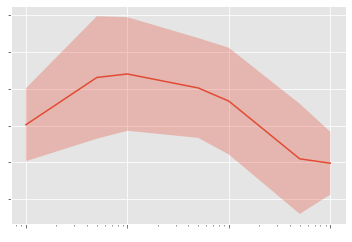

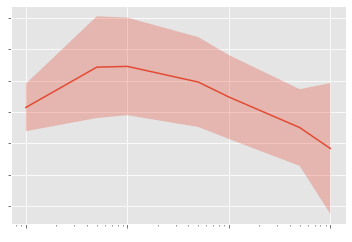

zeros: 0.886526775317979, means: 0.8874473953506214
0.8083333333333333
0.8066666666666666


In [293]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn import metrics

def plot_scores(optimizer):
    scores=[]
    for i in range(len(optimizer.cv_results_['params'])):
        scores.append([optimizer.cv_results_['params'][i]['C'], 
                optimizer.cv_results_['mean_test_score'][i],
                optimizer.cv_results_['std_test_score'][i]])
    scores = np.array(scores)
    plt.semilogx(scores[:,0], scores[:,1])
    plt.fill_between(scores[:,0], scores[:,1]-scores[:,2], 
                                 scores[:,1]+scores[:,2], alpha=0.3)
    plt.show()
    
def write_answer_1(auc_1, auc_2):
    auc = (auc_1 + auc_2)/2
    with open("preprocessing_lr_answer1.txt", "w") as fout:
        fout.write(str(auc))
    
param_grid = {'C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10]}
cv = 3

###### First part
print(type(X_train_real_zeros))
zeroes_train_data = np.hstack((X_train_real_zeros, X_train_cat_oh))
means_train_data = np.hstack((X_train_real_mean, X_train_cat_oh))

zeroes_test_data = np.hstack((X_test_real_zeros, X_test_cat_oh))
means_test_data = np.hstack((X_test_real_mean, X_test_cat_oh))

print(zeroes_train_data.shape, means_train_data.shape)
print(X_test_real_zeros.shape, X_test_real_mean.shape, X_test_cat_oh.shape)
# print(y_train.shape, y_test.shape)
print('--------------------------------')

###### Second part
estimator1 = LogisticRegression()
optimizer_zeros = GridSearchCV(estimator1, param_grid=param_grid, cv=3)
optimizer_zeros.fit(zeroes_train_data, y_train)
# print(optimizer_zeros.cv_results_['mean_test_score'])


print('--------------------------------')
estimator2 = LogisticRegression()
optimizer_means = GridSearchCV(estimator2, param_grid=param_grid, cv=3)
optimizer_means.fit(means_train_data, y_train)
# print(optimizer_means.cv_results_['mean_test_score'])

###### Third part
plot_scores(optimizer_zeros)
plot_scores(optimizer_means)

###### Fourth part
test_rock_zeros = roc_auc_score(y_test, optimizer_zeros.predict_proba(zeroes_test_data)[:, 1])
test_rock_means = roc_auc_score(y_test, optimizer_means.predict_proba(means_test_data)[:, 1])
print('zeros: {}, means: {}'.format(test_rock_zeros, test_rock_means))

###### Fifrth part
write_answer_1(test_rock_means, test_rock_zeros)


print(metrics.accuracy_score(y_test, optimizer_zeros.predict(zeroes_test_data)))
print(metrics.accuracy_score(y_test, optimizer_means.predict(means_test_data)))

## Масштабирование вещественных признаков.

Попробуем как-то улучшить качество классификации. Для этого посмотрим на сами данные:

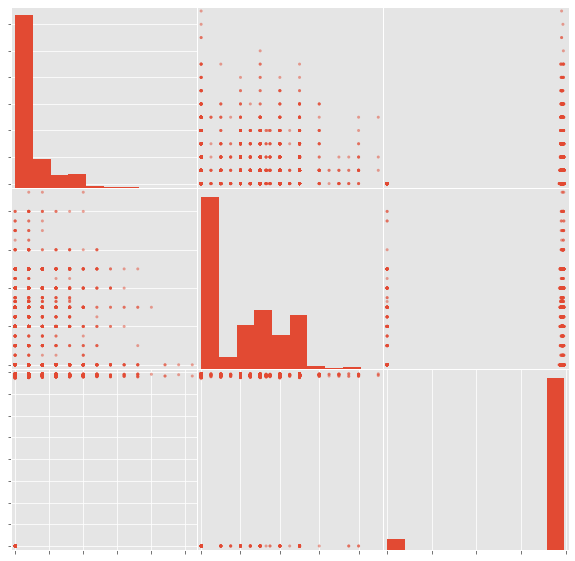

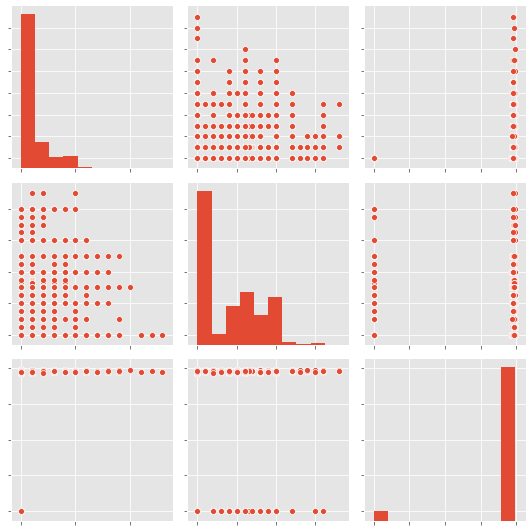

In [294]:
from pandas.plotting import scatter_matrix
import seaborn as sns

data_numeric = pd.DataFrame(X_train_real_zeros, columns=numeric_cols)
list_cols = ['Number.of.Successful.Grant.1', 'SEO.Percentage.2', 'Year.of.Birth.1']
scatter_matrix(data_numeric[list_cols], alpha=0.5, figsize=(10, 10))
plt.show()
sns.pairplot(data_numeric[list_cols])

Как видно из графиков, разные признаки очень сильно отличаются друг от друга по модулю значений (обратите внимание на диапазоны значений осей x и y). В случае обычной регрессии это никак не влияет на качество обучаемой модели, т.к. у меньших по модулю признаков будут большие веса, но при использовании регуляризации, которая штрафует модель за большие веса, регрессия, как правило, начинает работать хуже.

В таких случаях всегда рекомендуется делать стандартизацию (масштабирование) признаков, для того чтобы они меньше отличались друг друга по модулю, но при этом не нарушались никакие другие свойства признакового пространства. При этом даже если итоговое качество модели на тесте уменьшается, это повышает её интерпретабельность, потому что новые веса имеют смысл "значимости" данного признака для итоговой классификации.

Стандартизация осуществляется посредством вычета из каждого признака среднего значения и нормировки на выборочное стандартное отклонение:

$$ x^{scaled}_{id} = \dfrac{x_{id} - \mu_d}{\sigma_d}, \quad \mu_d = \frac{1}{N} \sum_{i=1}^l x_{id}, \quad \sigma_d = \sqrt{\frac{1}{N-1} \sum_{i=1}^l (x_{id} - \mu_d)^2} $$

## Задание 1.5. Масштабирование вещественных признаков.

1. По аналогии с вызовом one-hot encoder примените масштабирование вещественных признаков для обучающих и тестовых выборок X_train_real_zeros и X_test_real_zeros, используя класс 

        StandardScaler
   
   и методы 

        StandardScaler.fit_transform(...)
        StandardScaler.transform(...)
2. Сохраните ответ в переменные X_train_real_scaled и X_test_real_scaled соответственно

In [295]:
from sklearn.preprocessing import StandardScaler

# use data filled with mean numbers in empty cells
scaler = StandardScaler()
scaler.fit(X_train_real_zeros, y_train)
X_train_real_scaled = scaler.transform(X_train_real_zeros)
X_test_real_scaled = scaler.transform(X_test_real_zeros)

## Сравнение признаковых пространств.

Построим такие же графики для преобразованных данных:

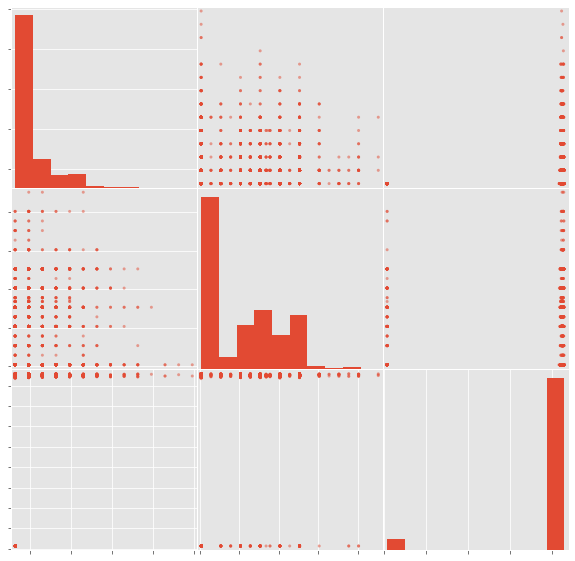

In [296]:
data_numeric_scaled = pd.DataFrame(X_train_real_scaled, columns=numeric_cols)
list_cols = ['Number.of.Successful.Grant.1', 'SEO.Percentage.2', 'Year.of.Birth.1']
scatter_matrix(data_numeric_scaled[list_cols], alpha=0.5, figsize=(10, 10))
plt.show()

Как видно из графиков, мы не поменяли свойства признакового пространства: гистограммы распределений значений признаков, как и их scatter-plots, выглядят так же, как и до нормировки, но при этом все значения теперь находятся примерно в одном диапазоне, тем самым повышая интерпретабельность результатов, а также лучше сочетаясь с идеологией регуляризации.

## Задание 2. Сравнение качества классификации до и после масштабирования вещественных признаков.
1. Обучите ещё раз регрессию и гиперпараметры на новых признаках, объединив их с закодированными категориальными.
2. Проверьте, был ли найден оптимум accuracy по гиперпараметрам во время кроссвалидации.
3. Получите значение ROC AUC на тестовой выборке, сравните с лучшим результатом, полученными ранее.
4. Запишите полученный ответ в файл при помощи функции write_answer_2.

0.795
0.885044379082622


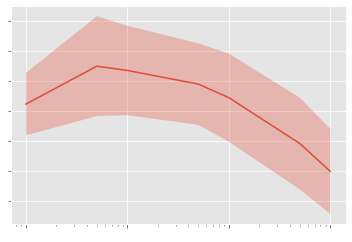

CPU times: user 15.6 s, sys: 1.77 s, total: 17.4 s
Wall time: 2.69 s


In [297]:
%%time
def write_answer_2(auc):
    with open("preprocessing_lr_answer2.txt", "w") as fout:
        fout.write(str(auc))


X_train_real_scaled = np.hstack((X_train_real_scaled, X_train_cat_oh))
X_test_real_scaled = np.hstack((X_test_real_scaled, X_test_cat_oh))

estimator_scaled = LogisticRegression()
optimizer_scaled = GridSearchCV(estimator_scaled, param_grid=param_grid, cv=3)
optimizer_scaled.fit(X_train_real_scaled, y_train)

print(optimizer_scaled.best_score_)

test_rock_scaled = roc_auc_score(y_test, optimizer_scaled.predict_proba(X_test_real_scaled)[:, 1])
print(test_rock_scaled)

plot_scores(optimizer_scaled)
write_answer_2(test_rock_scaled)

## Балансировка классов.

Алгоритмы классификации могут быть очень чувствительны к несбалансированным классам. Рассмотрим пример с выборками, сэмплированными из двух гауссиан. Их мат. ожидания и матрицы ковариации заданы так, что истинная разделяющая поверхность должна проходить параллельно оси x. Поместим в обучающую выборку 20 объектов, сэмплированных из 1-й гауссианы, и 10 объектов из 2-й. После этого обучим на них линейную регрессию, и построим на графиках объекты и области классификации.

(300, 300)
(300, 300)
(90000, 2)


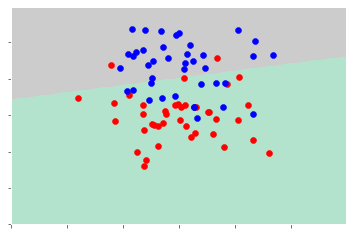

AUC: 0.906667


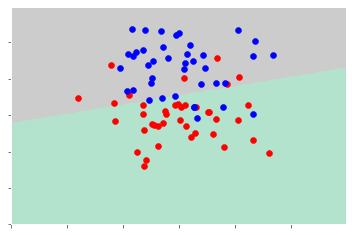

AUC: 0.895000


In [298]:
np.random.seed(0)
"""Сэмплируем данные из первой гауссианы"""
data_0 = np.random.multivariate_normal([0,0], [[0.5,0],[0,0.5]], size=40)
"""И из второй"""
data_1 = np.random.multivariate_normal([0,1], [[0.5,0],[0,0.5]], size=40)
"""На обучение берём 20 объектов из первого класса и 10 из второго"""
example_data_train = np.vstack([data_0[:20,:], data_1[:10,:]])
example_labels_train = np.concatenate([np.zeros((20)), np.ones((10))])
"""На тест - 20 из первого и 30 из второго"""
example_data_test = np.vstack([data_0[20:,:], data_1[10:,:]])
example_labels_test = np.concatenate([np.zeros((20)), np.ones((30))])
"""Задаём координатную сетку, на которой будем вычислять область классификации"""
xx, yy = np.meshgrid(np.arange(-3, 3, 0.02), np.arange(-3, 3, 0.02))
print(xx.shape)
print(yy.shape)
"""Обучаем регрессию без балансировки по классам"""
optimizer = GridSearchCV(LogisticRegression(), param_grid, cv=cv, n_jobs=-1)
optimizer.fit(example_data_train, example_labels_train)
"""Строим предсказания регрессии для сетки"""
print(np.c_[xx.ravel(), yy.ravel()].shape)
Z = optimizer.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Pastel2)
plt.scatter(data_0[:,0], data_0[:,1], color='red')
plt.scatter(data_1[:,0], data_1[:,1], color='blue')
"""Считаем AUC"""
auc_wo_class_weights = roc_auc_score(example_labels_test, optimizer.predict_proba(example_data_test)[:,1])
plt.title('Without class weights')
plt.show()
print('AUC: %f'%auc_wo_class_weights)
"""Для второй регрессии в LogisticRegression передаём параметр class_weight='balanced'"""
optimizer = GridSearchCV(LogisticRegression(class_weight='balanced'), param_grid, cv=cv, n_jobs=-1)
optimizer.fit(example_data_train, example_labels_train)
Z = optimizer.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Pastel2)
plt.scatter(data_0[:,0], data_0[:,1], color='red')
plt.scatter(data_1[:,0], data_1[:,1], color='blue')
auc_w_class_weights = roc_auc_score(example_labels_test, optimizer.predict_proba(example_data_test)[:,1])
plt.title('With class weights')
plt.show()
print('AUC: %f'%auc_w_class_weights)

Как видно, во втором случае классификатор находит разделяющую поверхность, которая ближе к истинной, т.е. меньше переобучается. Поэтому на сбалансированность классов в обучающей выборке всегда следует обращать внимание.

Посмотрим, сбалансированны ли классы в нашей обучающей выборке:

In [299]:
print(np.sum(y_train==0))
print(np.sum(y_train==1))

2316
1884


Видно, что нет.

Исправить ситуацию можно разными способами, мы рассмотрим два:
- давать объектам миноритарного класса больший вес при обучении классификатора (рассмотрен в примере выше)
- досэмплировать объекты миноритарного класса, пока число объектов в обоих классах не сравняется

## Задание 3. Балансировка классов.
1. Обучите логистическую регрессию и гиперпараметры с балансировкой классов, используя веса (параметр class_weight='balanced' регрессии) на отмасштабированных выборках, полученных в предыдущем задании. Убедитесь, что вы нашли максимум accuracy по гиперпараметрам.
2. Получите метрику ROC AUC на тестовой выборке.
3. Сбалансируйте выборку, досэмплировав в неё объекты из меньшего класса. Для получения индексов объектов, которые требуется добавить в обучающую выборку, используйте следующую комбинацию вызовов функций:
        np.random.seed(0)
        indices_to_add = np.random.randint(...)
        X_train_to_add = X_train[y_train.as_matrix() == 1,:][indices_to_add,:]
   После этого добавьте эти объекты в начало или конец обучающей выборки. Дополните соответствующим      образом вектор ответов.
4. Получите метрику ROC AUC на тестовой выборке, сравните с предыдущим результатом.
5. Внесите ответы в выходной файл при помощи функции write_asnwer_3, передав в неё сначала ROC AUC для балансировки весами, а потом балансировки выборки вручную.

In [300]:
def write_answer_3(auc_1, auc_2):
    auc = (auc_1 + auc_2) / 2
    with open("preprocessing_lr_answer3.txt", "w") as fout:
        fout.write(str(auc))
        
## class-weight='balanced'
estimator_scaled = LogisticRegression(class_weight='balanced')
optimizer_scaled = GridSearchCV(estimator_scaled, param_grid=param_grid, cv=3, n_jobs=-1)

optimizer_scaled.fit(X_train_real_scaled, y_train)
print(optimizer_scaled.best_score_)

test_rock_scaled = roc_auc_score(y_test, optimizer_scaled.predict_proba(X_test_real_scaled)[:, 1])
print(optimizer_scaled.best_score_)
print(test_rock_scaled)
# plot_scores(optimizer_scaled)
print('-------------------------------------')

## manual balancing of classes
classes_indexes = y_train == 1
first_class_indexes = np.array([])
# first_class_objects = np.full((0, X_test_real_scaled.shape[1]), 0)

for idx, class_number in enumerate(classes_indexes):
    if (class_number[0] == 1):
        first_class_indexes = np.append(first_class_indexes, idx)
        
first_class_indexes = np.array([int(x) for x in first_class_indexes])
first_class_objects = X_train_real_scaled[first_class_indexes]
print(first_class_objects.shape)
print('-------------------------------------')

## get random indexes of objects wich will be added to train dataset
np.random.seed(0)
print(np.sum(y_train==0) - np.sum(y_train==1))
X_extension = X_train_real_scaled[np.random.randint(0, first_class_objects.shape[0],
                                                                size=np.sum(y_train==0) - np.sum(y_train==1))]

print(X_extension.shape)

X_train_real_scaled_extended = np.vstack((np.copy(X_train_real_scaled), X_extension))
y_train_extended = np.vstack((np.copy(y_train), np.ones((432, 1))))

print(X_train_real_scaled.shape, y_train_extended.shape)
print('-------------------------------------')

## train on manually balanced data
estimator_scaled = LogisticRegression()
optimizer_scaled = GridSearchCV(estimator_scaled, param_grid=param_grid, cv=3, n_jobs=-1)

optimizer_scaled.fit(X_train_real_scaled_extended, y_train_extended)
print(optimizer_scaled.best_score_)

test_rock_manual_scaled = roc_auc_score(y_test, optimizer_scaled.predict_proba(X_test_real_scaled)[:, 1])
print(test_rock_manual_scaled)


## write results in file
write_answer_3(test_rock_scaled, test_rock_manual_scaled)

0.7885714285714286
0.7885714285714286
0.8871850681370189
-------------------------------------
(1884, 5606)
-------------------------------------
432
(432, 5606)
(4200, 5606) (4632, 1)
-------------------------------------
0.7549654576856649
0.887018020147225


## Стратификация выборок.

Рассмотрим ещё раз пример с выборками из нормальных распределений. Посмотрим ещё раз на качество классификаторов, получаемое на тестовых выборках:

In [302]:
print('AUC ROC for classifier without weighted classes', auc_wo_class_weights)
print('AUC ROC for classifier with weighted classes: ', auc_w_class_weights)

AUC ROC for classifier without weighted classes 0.9066666666666666
AUC ROC for classifier with weighted classes:  0.895


Насколько эти цифры реально отражают качество работы алгоритма, если учесть, что тестовая выборка так же несбалансирована, как обучающая? При этом мы уже знаем, что алгоритм логистический регрессии чувствителен к балансировке классов в обучающей выборке, т.е. в данном случае на тесте он будет давать заведомо заниженные результаты. Метрика классификатора на тесте имела бы гораздо больший смысл, если бы объекты были разделы в выборках поровну: по 20 из каждого класса на обучени и на тесте. Переформируем выборки и подсчитаем новые ошибки:

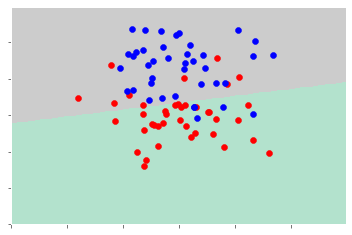

AUC ROC for stratified samples:  0.91


In [303]:
"""Разделим данные по классам поровну между обучающей и тестовой выборками"""
example_data_train = np.vstack([data_0[:20,:], data_1[:20,:]])
example_labels_train = np.concatenate([np.zeros((20)), np.ones((20))])
example_data_test = np.vstack([data_0[20:,:], data_1[20:,:]])
example_labels_test = np.concatenate([np.zeros((20)), np.ones((20))])
"""Обучим классификатор"""
optimizer = GridSearchCV(LogisticRegression(class_weight='balanced'), param_grid, cv=cv, n_jobs=-1)
optimizer.fit(example_data_train, example_labels_train)
Z = optimizer.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Pastel2)
plt.scatter(data_0[:,0], data_0[:,1], color='red')
plt.scatter(data_1[:,0], data_1[:,1], color='blue')
auc_stratified = roc_auc_score(example_labels_test, optimizer.predict_proba(example_data_test)[:,1])
plt.title('With class weights')
plt.show()
print('AUC ROC for stratified samples: ', auc_stratified)

Как видно, после данной процедуры ответ классификатора изменился незначительно, а вот качество увеличилось. При этом, в зависимости от того, как вы разбили изначально данные на обучение и тест, после сбалансированного разделения выборок итоговая метрика на тесте может как увеличиться, так и уменьшиться, но доверять ей можно значительно больше, т.к. она построена с учётом специфики работы классификатора. Данный подход является частным случаем т.н. метода стратификации.

## Задание 4. Стратификация выборки.

1. По аналогии с тем, как это было сделано в начале задания, разбейте выборки X_real_zeros и X_cat_oh на обучение и тест, передавая в функцию 
        train_test_split(...)
   дополнительно параметр 
       stratify=y
   Также обязательно передайте в функцию переменную random_state=0.
2. Выполните масштабирование новых вещественных выборок, обучите классификатор и его гиперпараметры при помощи метода кросс-валидации, делая поправку на несбалансированные классы при помощи весов. Убедитесь в том, что нашли оптимум accuracy по гиперпараметрам.
3. Оцените качество классификатора метрике AUC ROC на тестовой выборке.
4. Полученный ответ передайте функции write_answer_4

In [311]:
def write_answer_4(auc):
    with open("preprocessing_lr_answer4.txt", "w") as fout:
        fout.write(str(auc))
        
(X_train_real_zeros_task_4,
 X_test_real_zeros_task_4,
 y_train_4, y_test_4) = train_test_split(X_real_zeros, y.values.reshape(6000, 1), 
                                     test_size=0.3, 
                                     random_state=0, stratify=y)

(X_train_cat_oh_4,
 X_test_cat_oh_4) = train_test_split(X_cat_oh, 
                                   test_size=0.3,
                                   random_state=0, stratify=y)

scaler = StandardScaler()
scaler.fit(X_train_real_zeros_task_4, y_train_4)
X_train_real_scaled_4 = scaler.transform(X_train_real_zeros_task_4)
X_test_real_scaled_4 = scaler.transform(X_test_real_zeros_task_4)

zeroes_train_data_4 = np.hstack((X_train_real_scaled_4, X_train_cat_oh_4))
zeroes_test_data_4 = np.hstack((X_test_real_scaled_4, X_test_cat_oh_4))


estimator_4 = LogisticRegression(class_weight='balanced')
optimizer_4 = GridSearchCV(estimator_4, param_grid=param_grid, cv=3)

optimizer_4.fit(zeroes_train_data_4, y_train_4)
print(optimizer_4.best_score_)

test_rock_scaled_4 = roc_auc_score(y_test_4, optimizer_4.predict_proba(zeroes_test_data_4)[:, 1])
print(test_rock_scaled_4)

write_answer_4(test_rock_scaled_4)

0.8016666666666666
0.879348713049622


Теперь вы разобрались с основными этапами предобработки данных для линейных классификаторов.
Напомним основные этапы:
- обработка пропущенных значений
- обработка категориальных признаков
- стратификация
- балансировка классов
- масштабирование

Данные действия с данными рекомендуется проводить всякий раз, когда вы планируете использовать линейные методы. Рекомендация по выполнению многих из этих пунктов справедлива и для других методов машинного обучения.

## Трансформация признаков.

Теперь рассмотрим способы преобразования признаков. Существует достаточно много различных способов трансформации признаков, которые позволяют при помощи линейных методов получать более сложные разделяющие поверхности. Самым базовым является полиномиальное преобразование признаков. Его идея заключается в том, что помимо самих признаков вы дополнительно включаете набор все полиномы степени $p$, которые можно из них построить. Для случая $p=2$ преобразование выглядит следующим образом:

$$ \phi(x_i) = [x_{i,1}^2, ..., x_{i,D}^2, x_{i,1}x_{i,2}, ..., x_{i,D} x_{i,D-1}, x_{i,1}, ..., x_{i,D}, 1] $$

Рассмотрим принцип работы данных признаков на данных, сэмплированных их гауссиан:

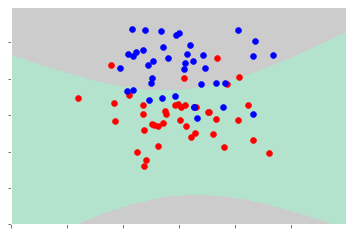

In [313]:
from sklearn.preprocessing import PolynomialFeatures

"""Инициализируем класс, который выполняет преобразование"""
transform = PolynomialFeatures(2)
"""Обучаем преобразование на обучающей выборке, применяем его к тестовой"""
example_data_train_poly = transform.fit_transform(example_data_train)
example_data_test_poly = transform.transform(example_data_test)
"""Обращаем внимание на параметр fit_intercept=False"""
optimizer = GridSearchCV(LogisticRegression(class_weight='balanced', fit_intercept=False), param_grid, cv=cv)
optimizer.fit(example_data_train_poly, example_labels_train)
Z = optimizer.predict(transform.transform(np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Pastel2)
plt.scatter(data_0[:,0], data_0[:,1], color='red')
plt.scatter(data_1[:,0], data_1[:,1], color='blue')
plt.title('With class weights')
plt.show()

Видно, что данный метод преобразования данных уже позволяет строить нелинейные разделяющие поверхности, которые могут более тонко подстраиваться под данные и находить более сложные зависимости. Число признаков в новой модели:

In [314]:
print(example_data_train_poly.shape)

(40, 6)


Но при этом одновременно данный метод способствует более сильной способности модели к переобучению из-за быстрого роста числа признаком с увеличением степени $p$. Рассмотрим пример с $p=11$:

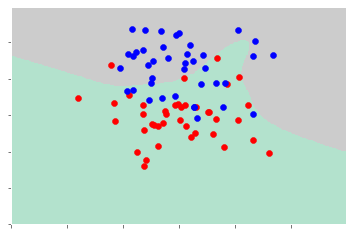

In [316]:
transform = PolynomialFeatures(11)
example_data_train_poly = transform.fit_transform(example_data_train)
example_data_test_poly = transform.transform(example_data_test)
optimizer = GridSearchCV(LogisticRegression(class_weight='balanced', fit_intercept=False), param_grid, cv=cv)
optimizer.fit(example_data_train_poly, example_labels_train)
Z = optimizer.predict(transform.transform(np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Pastel2)
plt.scatter(data_0[:,0], data_0[:,1], color='red')
plt.scatter(data_1[:,0], data_1[:,1], color='blue')
plt.title('Corrected class weights')
plt.show()

Количество признаков в данной модели:

In [317]:
print(example_data_train_poly.shape)

(40, 78)


## Задание 5. Трансформация вещественных признаков.

1. Реализуйте по аналогии с примером преобразование вещественных признаков модели при помощи полиномиальных признаков степени 2
2. Постройте логистическую регрессию на новых данных, одновременно подобрав оптимальные гиперпараметры. Обращаем внимание, что в преобразованных признаках уже присутствует столбец, все значения которого равны 1, поэтому обучать дополнительно значение $b$ не нужно, его функцию выполняет один из весов $w$. В связи с этим во избежание линейной зависимости в датасете, в вызов класса логистической регрессии требуется передавать параметр fit_intercept=False. Для обучения используйте стратифицированные выборки с балансировкой классов при помощи весов, преобразованные признаки требуется заново отмасштабировать.
3. Получите AUC ROC на тесте и сравните данный результат с использованием обычных признаков.
4. Передайте полученный ответ в функцию write_answer_5.

In [320]:
def write_answer_5(auc):
    with open("preprocessing_lr_answer5.txt", "w") as fout:
        fout.write(str(auc))


(X_train_real_zeros_task_5,
 X_test_real_zeros_task_5,
 y_train_5, y_test_5) = train_test_split(X_real_zeros, y.values.reshape(6000, 1), 
                                     test_size=0.3, 
                                     random_state=0, stratify=y)

transform = PolynomialFeatures(2)
transform.fit(X_train_real_zeros_task_5)
polynomial_train_transformed_5 = transform.transform(X_train_real_zeros_task_5)
poynomial_test_transformed_5 = transform.transform(X_test_real_zeros_task_5)


(X_train_cat_oh_5,
 X_test_cat_oh_5) = train_test_split(X_cat_oh, 
                                   test_size=0.3,
                                   random_state=0, stratify=y)

scaler = StandardScaler()
scaler.fit(polynomial_train_transformed_5, y_train_5)
polynomial_train_scaled_5 = scaler.transform(polynomial_train_transformed_5)
polynomial_test_scaled_5 = scaler.transform(poynomial_test_transformed_5)

zeroes_train_data_5 = np.hstack((polynomial_train_scaled_5, X_train_cat_oh_5))
zeroes_test_data_5 = np.hstack((polynomial_test_scaled_5, X_test_cat_oh_5))


estimator_5 = LogisticRegression(class_weight='balanced', fit_intercept=False)
optimizer_5 = GridSearchCV(estimator_5, param_grid=param_grid, cv=3)

optimizer_5.fit(zeroes_train_data_5, y_train_5)
print(optimizer_5.best_score_)

test_rock_5 = roc_auc_score(y_test_5, optimizer_5.predict_proba(zeroes_test_data_5)[:, 1])
print(test_rock_5)

write_answer_5(test_rock_5)

0.8054761904761905
0.8869913025739007


## Регрессия Lasso.
К логистической регрессии также можно применить L1-регуляризацию (Lasso), вместо регуляризации L2, которая будет приводить к отбору признаков. Вам предлагается применить L1-регуляцию к исходным признакам и проинтерпретировать полученные результаты (применение отбора признаков к полиномиальным так же можно успешно применять, но в нём уже будет отсутствовать компонента интерпретации, т.к. смысловое значение оригинальных признаков известно, а полиномиальных - уже может быть достаточно нетривиально). Для вызова логистической регрессии с L1-регуляризацией достаточно передать параметр penalty='l1' в инициализацию класса.

## Задание 6. Отбор признаков при помощи регрессии Lasso.
1. Обучите регрессию Lasso на стратифицированных отмасштабированных выборках, используя балансировку классов при помощи весов.
2. Получите ROC AUC регрессии, сравните его с предыдущими результатами.
3. Найдите номера вещественных признаков, которые имеют нулевые веса в итоговой модели.
4. Передайте их список функции write_answer_6.

In [335]:
def write_answer_6(features):
    with open("preprocessing_lr_answer6.txt", "w") as fout:
        fout.write(" ".join([str(num) for num in features]))
        
(X_train_real_zeros_task_4,
 X_test_real_zeros_task_4,
 y_train_4, y_test_4) = train_test_split(X_real_zeros, y.values.reshape(6000, 1), 
                                     test_size=0.3, 
                                     random_state=0, stratify=y)

(X_train_cat_oh_4,
 X_test_cat_oh_4) = train_test_split(X_cat_oh, 
                                   test_size=0.3,
                                   random_state=0, stratify=y)

scaler = StandardScaler()
scaler.fit(X_train_real_zeros_task_4, y_train_4)
X_train_real_scaled_4 = scaler.transform(X_train_real_zeros_task_4)
X_test_real_scaled_4 = scaler.transform(X_test_real_zeros_task_4)

print(X_train_real_scaled_4.shape)
zeroes_train_data_4 = np.hstack((X_train_real_scaled_4, X_train_cat_oh_4))
zeroes_test_data_4 = np.hstack((X_test_real_scaled_4, X_test_cat_oh_4))


estimator_4 = LogisticRegression(class_weight='balanced', penalty='l1')
optimizer_4 = GridSearchCV(estimator_4, param_grid=param_grid, cv=3)

optimizer_4.fit(zeroes_train_data_4, y_train_4)
print(optimizer_4.best_score_)

test_rock_scaled_4 = roc_auc_score(y_test_4, optimizer_4.predict_proba(zeroes_test_data_4)[:, 1])
print(test_rock_scaled_4)
print(optimizer_4.best_params_)
print(optimizer_4.best_estimator_.coef_)
coefs = np.array([round(x, 5) for x in optimizer_4.best_estimator_.coef_[0][:13]])
coefs = coefs == 0

result = []
for idx, x in enumerate(coefs):
    if x:
        result.append(idx)
print(result)

write_answer_6(result)

(4200, 13)
0.8076190476190476
0.8765785231292821
{'C': 1}
[[ 0.00762956  0.0385282  -0.09040184 ...  1.47993487  0.
   0.34603771]]
[4, 6, 7]
